# Project Checkpoint 3

In [45]:

import pandas as pd
import numpy as np
import joblib
import os
from pathlib import Path

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, classification_report,
    confusion_matrix
)

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

from imblearn.over_sampling import SMOTE, ADASYN

import warnings
warnings.filterwarnings('ignore')

import sklearn
print("All imports successful!")
print(f"Scikit-learn: {sklearn.__version__}")
print(f"Pandas: {pd.__version__}")
print(f"NumPy: {np.__version__}")

All imports successful!
Scikit-learn: 1.5.2
Pandas: 2.2.2
NumPy: 1.26.4


In [47]:
df = pd.read_csv('data/processed_bank_churn.csv')

print(f"Dataset loaded: {df.shape}")
print(f"\nColumns: {df.columns.tolist()}")
print(f"\nFirst 3 rows:")
print(df.head(3))
print(f"\nChurn distribution:")
print(df['Churn'].value_counts())
print(f"\nMissing values: {df.isnull().sum().sum()}")

Dataset loaded: (8100, 13)

Columns: ['Country_France', 'Country_Germany', 'Country_Spain', 'CreditScore', 'IsMale', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Churn']

First 3 rows:
   Country_France  Country_Germany  Country_Spain  CreditScore  IsMale  \
0               1                0              0    -0.111618       0   
1               1                0              0     1.830959       1   
2               1                0              0    -1.565954       0   

        Age    Tenure   Balance  NumOfProducts  HasCrCard  IsActiveMember  \
0 -0.779913  1.378786  1.006375      -0.911977          1               0   
1 -0.063481 -0.004997 -1.217802       0.807533          0               0   
2 -0.472870  0.340949 -1.217802      -0.911977          1               1   

   EstimatedSalary  Churn  
0        -0.890423      0  
1         0.062089      0  
2         0.706169      0  

Churn distribution:
Churn
0    6453
1    1647

In [49]:
scaler_path = Path('models/scaler.pkl')

if scaler_path.exists():
    scaler = joblib.load(scaler_path)
    print(f"Scaler loaded from {scaler_path}")
    print(f"   Scaler type: {type(scaler).__name__}")
else:
    print(f"ERROR: scaler.pkl not found at {scaler_path}")
    print("   This file should already exist. Check your setup.")
    raise FileNotFoundError(f"scaler.pkl not found")

Scaler loaded from models/scaler.pkl
   Scaler type: StandardScaler


In [51]:
X = df.drop('Churn', axis=1)
y = df['Churn']

print(f" Data prepared")
print(f"   Features shape: {X.shape}")
print(f"   Target shape: {y.shape}")
print(f"\n   Feature columns ({len(X.columns)}):")
for i, col in enumerate(X.columns, 1):
    print(f"   {i:2d}. {col}")

 Data prepared
   Features shape: (8100, 12)
   Target shape: (8100,)

   Feature columns (12):
    1. Country_France
    2. Country_Germany
    3. Country_Spain
    4. CreditScore
    5. IsMale
    6. Age
    7. Tenure
    8. Balance
    9. NumOfProducts
   10. HasCrCard
   11. IsActiveMember
   12. EstimatedSalary


In [53]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.15, random_state=42, stratify=y
)

In [55]:
print(f"\ Train-Test Split")
print(f"   Training set: {X_train.shape}")
print(f"   Test set: {X_test.shape}")
print(f"   Train class distribution: {y_train.value_counts().to_dict()}")
print(f"   Test class distribution: {y_test.value_counts().to_dict()}")


\ Train-Test Split
   Training set: (6885, 12)
   Test set: (1215, 12)
   Train class distribution: {0: 5485, 1: 1400}
   Test class distribution: {0: 968, 1: 247}


### APPLY SMOTE

In [58]:
print("\n" + "="*70)
print("APPLYING SMOTE")
print("="*70)

smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print(f"Before SMOTE: {y_train.value_counts().to_dict()}")
print(f"After SMOTE:  {y_train_smote.value_counts().to_dict()}")


APPLYING SMOTE
Before SMOTE: {0: 5485, 1: 1400}
After SMOTE:  {0: 5485, 1: 5485}


### APPLY ADASYN

In [61]:
print("\n" + "="*70)
print("APPLYING ADASYN")
print("="*70)

adasyn = ADASYN(random_state=42)
X_train_adasyn, y_train_adasyn = adasyn.fit_resample(X_train, y_train)

print(f"Before ADASYN: {y_train.value_counts().to_dict()}")
print(f"After ADASYN:  {y_train_adasyn.value_counts().to_dict()}")


APPLYING ADASYN
Before ADASYN: {0: 5485, 1: 1400}
After ADASYN:  {0: 5485, 1: 5263}


### Helper Funtions

In [64]:
def evaluate_model(model, X_test, y_test, model_name):
    """Comprehensive model evaluation"""
    y_pred = model.predict(X_test)
    
    if hasattr(model, 'predict_proba'):
        y_prob = model.predict_proba(X_test)[:, 1]
        roc_auc = roc_auc_score(y_test, y_prob)
    else:
        roc_auc = "N/A"
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    print(f"\n{'='*70}")
    print(f"{model_name}")
    print(f"{'='*70}")
    print(f"Accuracy:  {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1 Score:  {f1:.4f}")
    print(f"ROC-AUC:   {roc_auc if isinstance(roc_auc, str) else f'{roc_auc:.4f}'}")
    
    return {
        'model_name': model_name,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'roc_auc': roc_auc if isinstance(roc_auc, str) else roc_auc
    }

def grid_search_model(estimator, param_grid, X_train, y_train, X_test, y_test, model_name):
    """
    Perform GridSearchCV to find best model
    Returns best model and its evaluation metrics
    """
    print(f"\n{'='*70}")
    print(f"GridSearchCV: {model_name}")
    print(f"{'='*70}")
    print(f"Testing {len(param_grid)} parameter combinations...")
    
    start_time = time.time()
    
    # Use F1 score as primary metric (balances precision/recall)
    grid_search = GridSearchCV(
        estimator=estimator,
        param_grid=param_grid,
        scoring='f1',
        cv=5,
        n_jobs=-1,
        verbose=1
    )
    
    grid_search.fit(X_train, y_train)
    
    elapsed_time = time.time() - start_time
    
    print(f"\nBest parameters found in {elapsed_time:.1f}s:")
    for param, value in grid_search.best_params_.items():
        print(f"   {param}: {value}")
    print(f"\n   Best CV F1 Score: {grid_search.best_score_:.4f}")
    
    # Evaluate on test set
    best_model = grid_search.best_estimator_
    metrics = evaluate_model(best_model, X_test, y_test, model_name)
    
    return best_model, metrics, grid_search.best_params_

print("Helper functions defined!")


Helper functions defined!


### DEFINE HYPERPARAMETER GRIDS

In [67]:
param_grids = {
    'Logistic Regression': {
        'estimator': LogisticRegression(max_iter=1000, random_state=42),
        'params': {
            'C': [0.01, 0.1, 1, 10],
            'penalty': ['l2'],
            'solver': ['lbfgs', 'liblinear']
        }
    },
    
    'Decision Tree': {
        'estimator': DecisionTreeClassifier(random_state=42),
        'params': {
            'max_depth': [5, 7, 10, 15],
            'min_samples_split': [2, 10, 20],
            'min_samples_leaf': [10, 20, 30],
            'criterion': ['gini', 'entropy']
        }
    },
    
    'Random Forest': {
        'estimator': RandomForestClassifier(random_state=42),
        'params': {
            'n_estimators': [100, 200, 300],
            'max_depth': [8, 12, 15],
            'min_samples_leaf': [10, 20, 30],
            'max_features': ['sqrt', 'log2']
        }
    },
    
    'KNN': {
        'estimator': KNeighborsClassifier(),
        'params': {
            'n_neighbors': [5, 10, 15, 20],
            'weights': ['uniform', 'distance'],
            'metric': ['euclidean', 'manhattan']
        }
    },
    
    'SVM': {
        'estimator': SVC(probability=True, random_state=42),
        'params': {
            'C': [0.1, 1, 10],
            'gamma': ['scale', 0.1, 0.01],
            'kernel': ['rbf']
        }
    },
    
    'XGBoost': {
        'estimator': XGBClassifier(
            eval_metric='logloss',
            random_state=42,
            use_label_encoder=False,
            enable_categorical=False
        ),
        'params': {
            'n_estimators': [200, 300],
            'max_depth': [3, 5, 7],
            'learning_rate': [0.05, 0.1, 0.2],
            'subsample': [0.8, 1.0],
            'colsample_bytree': [0.8, 1.0]
        }
    }
}

for name, config in param_grids.items():
    n_combinations = 1
    for param_values in config['params'].values():
        n_combinations *= len(param_values)
    print(f"   {name}: {n_combinations} combinations")


   Logistic Regression: 8 combinations
   Decision Tree: 72 combinations
   Random Forest: 54 combinations
   KNN: 16 combinations
   SVM: 9 combinations
   XGBoost: 72 combinations


### TRAIN BEST MODELS - BASELINE (NO RESAMPLING)

In [70]:

import time
baseline_best_models = {}
baseline_results = []

for model_name, config in param_grids.items():
    best_model, metrics, best_params = grid_search_model(
        estimator=config['estimator'],
        param_grid=config['params'],
        X_train=X_train,
        y_train=y_train,
        X_test=X_test,
        y_test=y_test,
        model_name=f"{model_name} (Baseline)"
    )
    
    baseline_best_models[model_name] = {
        'model': best_model,
        'params': best_params,
        'metrics': metrics
    }
    baseline_results.append(metrics)



GridSearchCV: Logistic Regression (Baseline)
Testing 3 parameter combinations...
Fitting 5 folds for each of 8 candidates, totalling 40 fits

Best parameters found in 0.1s:
   C: 10
   penalty: l2
   solver: lbfgs

   Best CV F1 Score: 0.3756

Logistic Regression (Baseline)
Accuracy:  0.8091
Precision: 0.5773
Recall:    0.2267
F1 Score:  0.3256
ROC-AUC:   0.7680

GridSearchCV: Decision Tree (Baseline)
Testing 4 parameter combinations...
Fitting 5 folds for each of 72 candidates, totalling 360 fits

Best parameters found in 1.0s:
   criterion: entropy
   max_depth: 7
   min_samples_leaf: 10
   min_samples_split: 2

   Best CV F1 Score: 0.5806

Decision Tree (Baseline)
Accuracy:  0.8519
Precision: 0.7913
Recall:    0.3684
F1 Score:  0.5028
ROC-AUC:   0.8388

GridSearchCV: Random Forest (Baseline)
Testing 4 parameter combinations...
Fitting 5 folds for each of 54 candidates, totalling 270 fits

Best parameters found in 26.0s:
   max_depth: 12
   max_features: sqrt
   min_samples_leaf: 10

/Users/ajay/Documents/UMD Academics/projects/Bankchurn/venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [19:07:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ajay/Documents/UMD Academics/projects/Bankchurn/venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [19:07:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ajay/Documents/UMD Academics/projects/Bankchurn/venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [19:07:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ajay/Documents/UMD Academics/projects/Bankchurn/venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [19:07:16] WARNING: /U


Best parameters found in 7.2s:
   colsample_bytree: 0.8
   learning_rate: 0.1
   max_depth: 3
   n_estimators: 200
   subsample: 1.0

   Best CV F1 Score: 0.5942

XGBoost (Baseline)
Accuracy:  0.8609
Precision: 0.7500
Recall:    0.4737
F1 Score:  0.5806
ROC-AUC:   0.8607


### TRAIN BEST MODELS - SMOTE

In [75]:
smote_best_models = {}
smote_results = []

for model_name, config in param_grids.items():
    best_model, metrics, best_params = grid_search_model(
        estimator=config['estimator'],
        param_grid=config['params'],
        X_train=X_train_smote,
        y_train=y_train_smote,
        X_test=X_test,
        y_test=y_test,
        model_name=f"{model_name} (SMOTE)"
    )
    
    smote_best_models[model_name] = {
        'model': best_model,
        'params': best_params,
        'metrics': metrics
    }
    smote_results.append(metrics)



GridSearchCV: Logistic Regression (SMOTE)
Testing 3 parameter combinations...
Fitting 5 folds for each of 8 candidates, totalling 40 fits

Best parameters found in 0.2s:
   C: 1
   penalty: l2
   solver: lbfgs

   Best CV F1 Score: 0.7512

Logistic Regression (SMOTE)
Accuracy:  0.7251
Precision: 0.3926
Recall:    0.6437
F1 Score:  0.4877
ROC-AUC:   0.7668

GridSearchCV: Decision Tree (SMOTE)
Testing 4 parameter combinations...
Fitting 5 folds for each of 72 candidates, totalling 360 fits

Best parameters found in 1.9s:
   criterion: gini
   max_depth: 15
   min_samples_leaf: 10
   min_samples_split: 2

   Best CV F1 Score: 0.8223

Decision Tree (SMOTE)
Accuracy:  0.7811
Precision: 0.4682
Recall:    0.5668
F1 Score:  0.5128
ROC-AUC:   0.7801

GridSearchCV: Random Forest (SMOTE)
Testing 4 parameter combinations...
Fitting 5 folds for each of 54 candidates, totalling 270 fits

Best parameters found in 46.0s:
   max_depth: 15
   max_features: sqrt
   min_samples_leaf: 10
   n_estimators: 

/Users/ajay/Documents/UMD Academics/projects/Bankchurn/venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [19:09:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ajay/Documents/UMD Academics/projects/Bankchurn/venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [19:09:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ajay/Documents/UMD Academics/projects/Bankchurn/venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [19:09:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ajay/Documents/UMD Academics/projects/Bankchurn/venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [19:09:08] WARNING: /U


Best parameters found in 12.0s:
   colsample_bytree: 1.0
   learning_rate: 0.1
   max_depth: 7
   n_estimators: 300
   subsample: 0.8

   Best CV F1 Score: 0.8865

XGBoost (SMOTE)
Accuracy:  0.8412
Precision: 0.6286
Recall:    0.5344
F1 Score:  0.5777
ROC-AUC:   0.8340


### TRAIN BEST MODELS - ADASYN

In [78]:
adasyn_best_models = {}
adasyn_results = []

for model_name, config in param_grids.items():
    best_model, metrics, best_params = grid_search_model(
        estimator=config['estimator'],
        param_grid=config['params'],
        X_train=X_train_adasyn,
        y_train=y_train_adasyn,
        X_test=X_test,
        y_test=y_test,
        model_name=f"{model_name} (ADASYN)"
    )
    
    adasyn_best_models[model_name] = {
        'model': best_model,
        'params': best_params,
        'metrics': metrics
    }
    adasyn_results.append(metrics)


GridSearchCV: Logistic Regression (ADASYN)
Testing 3 parameter combinations...
Fitting 5 folds for each of 8 candidates, totalling 40 fits

Best parameters found in 0.2s:
   C: 0.1
   penalty: l2
   solver: lbfgs

   Best CV F1 Score: 0.7226

Logistic Regression (ADASYN)
Accuracy:  0.7160
Precision: 0.3833
Recall:    0.6518
F1 Score:  0.4828
ROC-AUC:   0.7602

GridSearchCV: Decision Tree (ADASYN)
Testing 4 parameter combinations...
Fitting 5 folds for each of 72 candidates, totalling 360 fits

Best parameters found in 2.1s:
   criterion: gini
   max_depth: 10
   min_samples_leaf: 10
   min_samples_split: 2

   Best CV F1 Score: 0.7703

Decision Tree (ADASYN)
Accuracy:  0.7547
Precision: 0.4294
Recall:    0.6275
F1 Score:  0.5099
ROC-AUC:   0.7848

GridSearchCV: Random Forest (ADASYN)
Testing 4 parameter combinations...
Fitting 5 folds for each of 54 candidates, totalling 270 fits

Best parameters found in 48.2s:
   max_depth: 15
   max_features: sqrt
   min_samples_leaf: 10
   n_estim

/Users/ajay/Documents/UMD Academics/projects/Bankchurn/venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [19:11:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ajay/Documents/UMD Academics/projects/Bankchurn/venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [19:11:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ajay/Documents/UMD Academics/projects/Bankchurn/venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [19:11:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ajay/Documents/UMD Academics/projects/Bankchurn/venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [19:11:00] WARNING: /U


Best parameters found in 12.0s:
   colsample_bytree: 1.0
   learning_rate: 0.2
   max_depth: 7
   n_estimators: 300
   subsample: 0.8

   Best CV F1 Score: 0.8802

XGBoost (ADASYN)
Accuracy:  0.8329
Precision: 0.6078
Recall:    0.5020
F1 Score:  0.5499
ROC-AUC:   0.8194


### COMPARE ALL APPROACHES & SELECT WINNERS

In [80]:
final_best_models = {}

for model_name in param_grids.keys():
    # Get F1 scores for each approach
    baseline_f1 = baseline_best_models[model_name]['metrics']['f1']
    smote_f1 = smote_best_models[model_name]['metrics']['f1']
    adasyn_f1 = adasyn_best_models[model_name]['metrics']['f1']
    
    # Find best approach
    scores = {
        'Baseline': (baseline_f1, baseline_best_models[model_name]),
        'SMOTE': (smote_f1, smote_best_models[model_name]),
        'ADASYN': (adasyn_f1, adasyn_best_models[model_name])
    }
    
    best_approach = max(scores.items(), key=lambda x: x[1][0])
    approach_name, (best_f1, best_config) = best_approach
    
    final_best_models[model_name] = {
        'approach': approach_name,
        'model': best_config['model'],
        'params': best_config['params'],
        'metrics': best_config['metrics']
    }
    
    print(f"\n{model_name}:")
    print(f"   Baseline F1: {baseline_f1:.4f}")
    print(f"   SMOTE F1:    {smote_f1:.4f}")
    print(f"   ADASYN F1:   {adasyn_f1:.4f}")
    print(f"   Winner:   {approach_name} (F1={best_f1:.4f})")



Logistic Regression:
   Baseline F1: 0.3256
   SMOTE F1:    0.4877
   ADASYN F1:   0.4828
   Winner:   SMOTE (F1=0.4877)

Decision Tree:
   Baseline F1: 0.5028
   SMOTE F1:    0.5128
   ADASYN F1:   0.5099
   Winner:   SMOTE (F1=0.5128)

Random Forest:
   Baseline F1: 0.5146
   SMOTE F1:    0.6030
   ADASYN F1:   0.5868
   Winner:   SMOTE (F1=0.6030)

KNN:
   Baseline F1: 0.4688
   SMOTE F1:    0.5133
   ADASYN F1:   0.5000
   Winner:   SMOTE (F1=0.5133)

SVM:
   Baseline F1: 0.5013
   SMOTE F1:    0.5442
   ADASYN F1:   0.5249
   Winner:   SMOTE (F1=0.5442)

XGBoost:
   Baseline F1: 0.5806
   SMOTE F1:    0.5777
   ADASYN F1:   0.5499
   Winner:   Baseline (F1=0.5806)


### SAVE BEST MODELS

In [85]:
os.makedirs('models', exist_ok=True)

model_filename_map = {
    'Logistic Regression': 'logistic_regression_smote_churn.pkl',
    'Decision Tree': 'decision_tree_smote_churn.pkl',
    'Random Forest': 'random_forest_smote_churn.pkl',
    'KNN': 'knn_smote_churn.pkl',
    'SVM': 'svm_smote_churn.pkl',
    'XGBoost': 'xgboost_smote_churn.pkl',
}

for model_name, config in final_best_models.items():
    filename = model_filename_map[model_name]
    path = f'models/{filename}'
    
    joblib.dump(config['model'], path, compress=3)
    size = os.path.getsize(path)
    
    print(f"\n {filename}")
    print(f"   Approach: {config['approach']}")
    print(f"   F1 Score: {config['metrics']['f1']:.4f}")
    print(f"   Recall:   {config['metrics']['recall']:.4f}")
    print(f"   Size:     {size:,} bytes")



 logistic_regression_smote_churn.pkl
   Approach: SMOTE
   F1 Score: 0.4877
   Recall:   0.6437
   Size:     977 bytes

 decision_tree_smote_churn.pkl
   Approach: SMOTE
   F1 Score: 0.5128
   Recall:   0.5668
   Size:     22,361 bytes

 random_forest_smote_churn.pkl
   Approach: SMOTE
   F1 Score: 0.6030
   Recall:   0.6518
   Size:     5,738,403 bytes

 knn_smote_churn.pkl
   Approach: SMOTE
   F1 Score: 0.5133
   Recall:   0.6235
   Size:     761,535 bytes

 svm_smote_churn.pkl
   Approach: SMOTE
   F1 Score: 0.5442
   Recall:   0.6235
   Size:     158,881 bytes

 xgboost_smote_churn.pkl
   Approach: Baseline
   F1 Score: 0.5806
   Recall:   0.4737
   Size:     41,930 bytes


### FINAL SUMMARY

In [94]:
summary_data = []
for model_name, config in final_best_models.items():
    summary_data.append({
        'Model': model_name,
        'Approach': config['approach'],
        'Accuracy': f"{config['metrics']['accuracy']:.4f}",
        'Precision': f"{config['metrics']['precision']:.4f}",
        'Recall': f"{config['metrics']['recall']:.4f}",
        'F1 Score': f"{config['metrics']['f1']:.4f}",
        'ROC-AUC': f"{config['metrics']['roc_auc']:.4f}" if isinstance(config['metrics']['roc_auc'], float) else 'N/A'
    })

summary_df = pd.DataFrame(summary_data)
summary_df = summary_df.sort_values('F1 Score', ascending=False)

print("\n Best Models Ranked by F1 Score:")
print(summary_df.to_string(index=False))

print("\n" + "="*70)
print("TRAINING COMPLETE!")
print("="*70)
print("\nSaved models:")
for filename in model_filename_map.values():
    print(f"  models/{filename}")



 Best Models Ranked by F1 Score:
              Model Approach Accuracy Precision Recall F1 Score ROC-AUC
      Random Forest    SMOTE   0.8255    0.5610 0.6518   0.6030  0.8522
            XGBoost Baseline   0.8609    0.7500 0.4737   0.5806  0.8607
                SVM    SMOTE   0.7877    0.4828 0.6235   0.5442  0.7977
                KNN    SMOTE   0.7597    0.4363 0.6235   0.5133  0.7725
      Decision Tree    SMOTE   0.7811    0.4682 0.5668   0.5128  0.7801
Logistic Regression    SMOTE   0.7251    0.3926 0.6437   0.4877  0.7668

TRAINING COMPLETE!

Saved models:
  models/logistic_regression_smote_churn.pkl
  models/decision_tree_smote_churn.pkl
  models/random_forest_smote_churn.pkl
  models/knn_smote_churn.pkl
  models/svm_smote_churn.pkl
  models/xgboost_smote_churn.pkl


The Random Forest model with SMOTE is the best overall model, with a F1 score of 0.6030 and strong recall of 0.5188 and competitive ROCAUC of 0.8522. This means it works best to fend for the best balance between correct detection of the churner and not overproducing false alarms that require it at high cost when they are trying to miss a churner.

One of the best choices is XGBoost Baseline with relatively good accuracy (0.8609) ROCAUC and slightly better recall (0.4737) and F1 score (0.5806). The business is only best served if it believes in overall accuracy and precision over churnrisk customers.

# Web Application

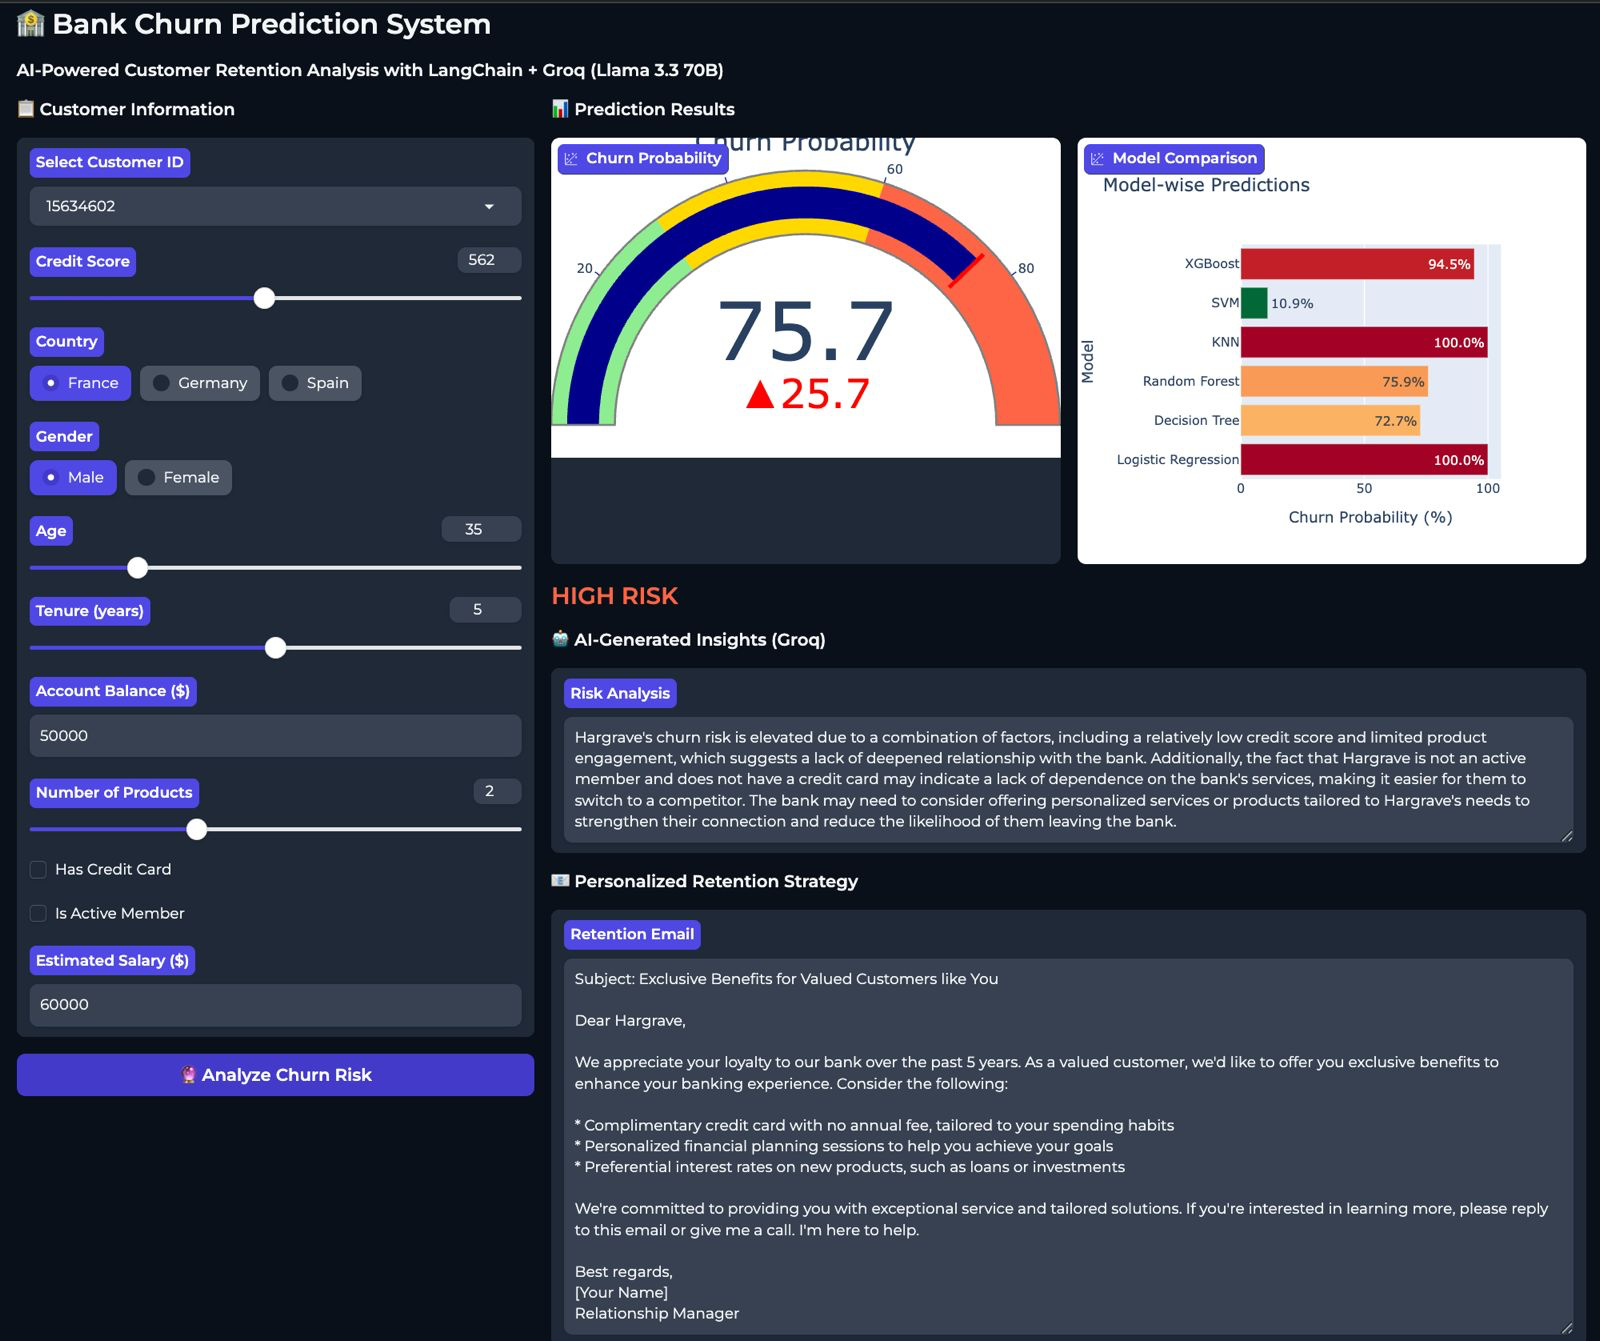